In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import tree

In [3]:
with open('./datasets/mod_05_topic_10_various_data.pkl', 'rb') as fl:
    datasets = pickle.load(fl)

In [4]:
# load autos dataset
autos = datasets['autos']
autos.head()

,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,audi,gas,std,4,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,audi,gas,std,4,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


In [5]:
# observe data types and missed data
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               193 non-null    object 
 1   fuel_type          193 non-null    object 
 2   aspiration         193 non-null    object 
 3   num_of_doors       193 non-null    int64  
 4   body_style         193 non-null    object 
 5   drive_wheels       193 non-null    object 
 6   engine_location    193 non-null    object 
 7   wheel_base         193 non-null    float64
 8   length             193 non-null    float64
 9   width              193 non-null    float64
 10  height             193 non-null    float64
 11  curb_weight        193 non-null    int64  
 12  engine_type        193 non-null    object 
 13  num_of_cylinders   193 non-null    int64  
 14  engine_size        193 non-null    int64  
 15  fuel_system        193 non-null    object 
 16  bore               193 non

In [6]:
# get dataset statistics
autos.describe()

,num_of_doors,wheel_base,length,width,height,curb_weight,num_of_cylinders,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,3.160622,98.923834,174.326425,65.893782,53.869948,2561.507772,4.419689,128.124352,3.330622,3.248860,9.860104,103.481865,5099.740933,25.326425,30.787565,13285.025907
std,0.989583,6.152409,12.478593,2.137795,2.394770,526.700026,1.023182,41.590452,0.272385,0.315421,4.002098,37.960107,468.694369,6.387828,6.816910,8089.082886
min,2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,3.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,2.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,4.000000,98.000000,3.150000,3.110000,8.000000,70.000000,4800.000000,19.000000,25.000000,7738.000000
50%,4.000000,97.000000,173.200000,65.400000,54.100000,2414.000000,4.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5100.000000,25.000000,30.000000,10245.000000
75%,4.000000,102.400000,184.600000,66.900000,55.700000,2952.000000,4.000000,146.000000,3.590000,3.410000,9.000000,116.000000,5500.000000,30.000000,34.000000,16515.000000
max,4.000000,120.900000,208.100000,72.000000,59.800000,4066.000000,12.000000,326.000000,3.940000,4.170000,23.000000,262.000000,6600.000000,49.000000,54.000000,45400.000000


In [7]:
# get list of descrete features
X=autos.copy()
y=X.pop('price')

cat_features=X.select_dtypes('object').columns
cat_features

Index(['make', 'fuel_type', 'aspiration', 'body_style', 'drive_wheels',
       'engine_location', 'engine_type', 'fuel_system'],
      dtype='object')

In [8]:
# convert descrete features into numerical ones
for colname in cat_features:
    X[colname], _ = X[colname].factorize()
    
X.dtypes

make                   int64
fuel_type              int64
aspiration             int64
num_of_doors           int64
body_style             int64
drive_wheels           int64
engine_location        int64
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_type            int64
num_of_cylinders       int64
engine_size            int64
fuel_system            int64
bore                 float64
stroke               float64
compression_ratio      int64
horsepower             int64
peak_rpm               int64
city_mpg               int64
highway_mpg            int64
dtype: object

In [9]:
# define mutual information scores
mi_scores = mutual_info_regression(X, y, discrete_features=X.columns.isin(cat_features.to_list()+['num_of_doors', 'num_of_cylinders']), random_state=42)

mi_scores = (pd.Series(mi_scores, name="MI Scores", index=X.columns).sort_values())

mi_scores

num_of_doors         0.012705
engine_location      0.036912
fuel_type            0.047298
body_style           0.080515
aspiration           0.087755
compression_ratio    0.093994
engine_type          0.151544
peak_rpm             0.234449
num_of_cylinders     0.330589
drive_wheels         0.332973
height               0.368335
stroke               0.383763
fuel_system          0.484140
bore                 0.497420
make                 0.543268
wheel_base           0.588635
length               0.612483
width                0.679991
city_mpg             0.774127
highway_mpg          0.887362
horsepower           0.891165
engine_size          0.900925
curb_weight          0.911713
Name: MI Scores, dtype: float64

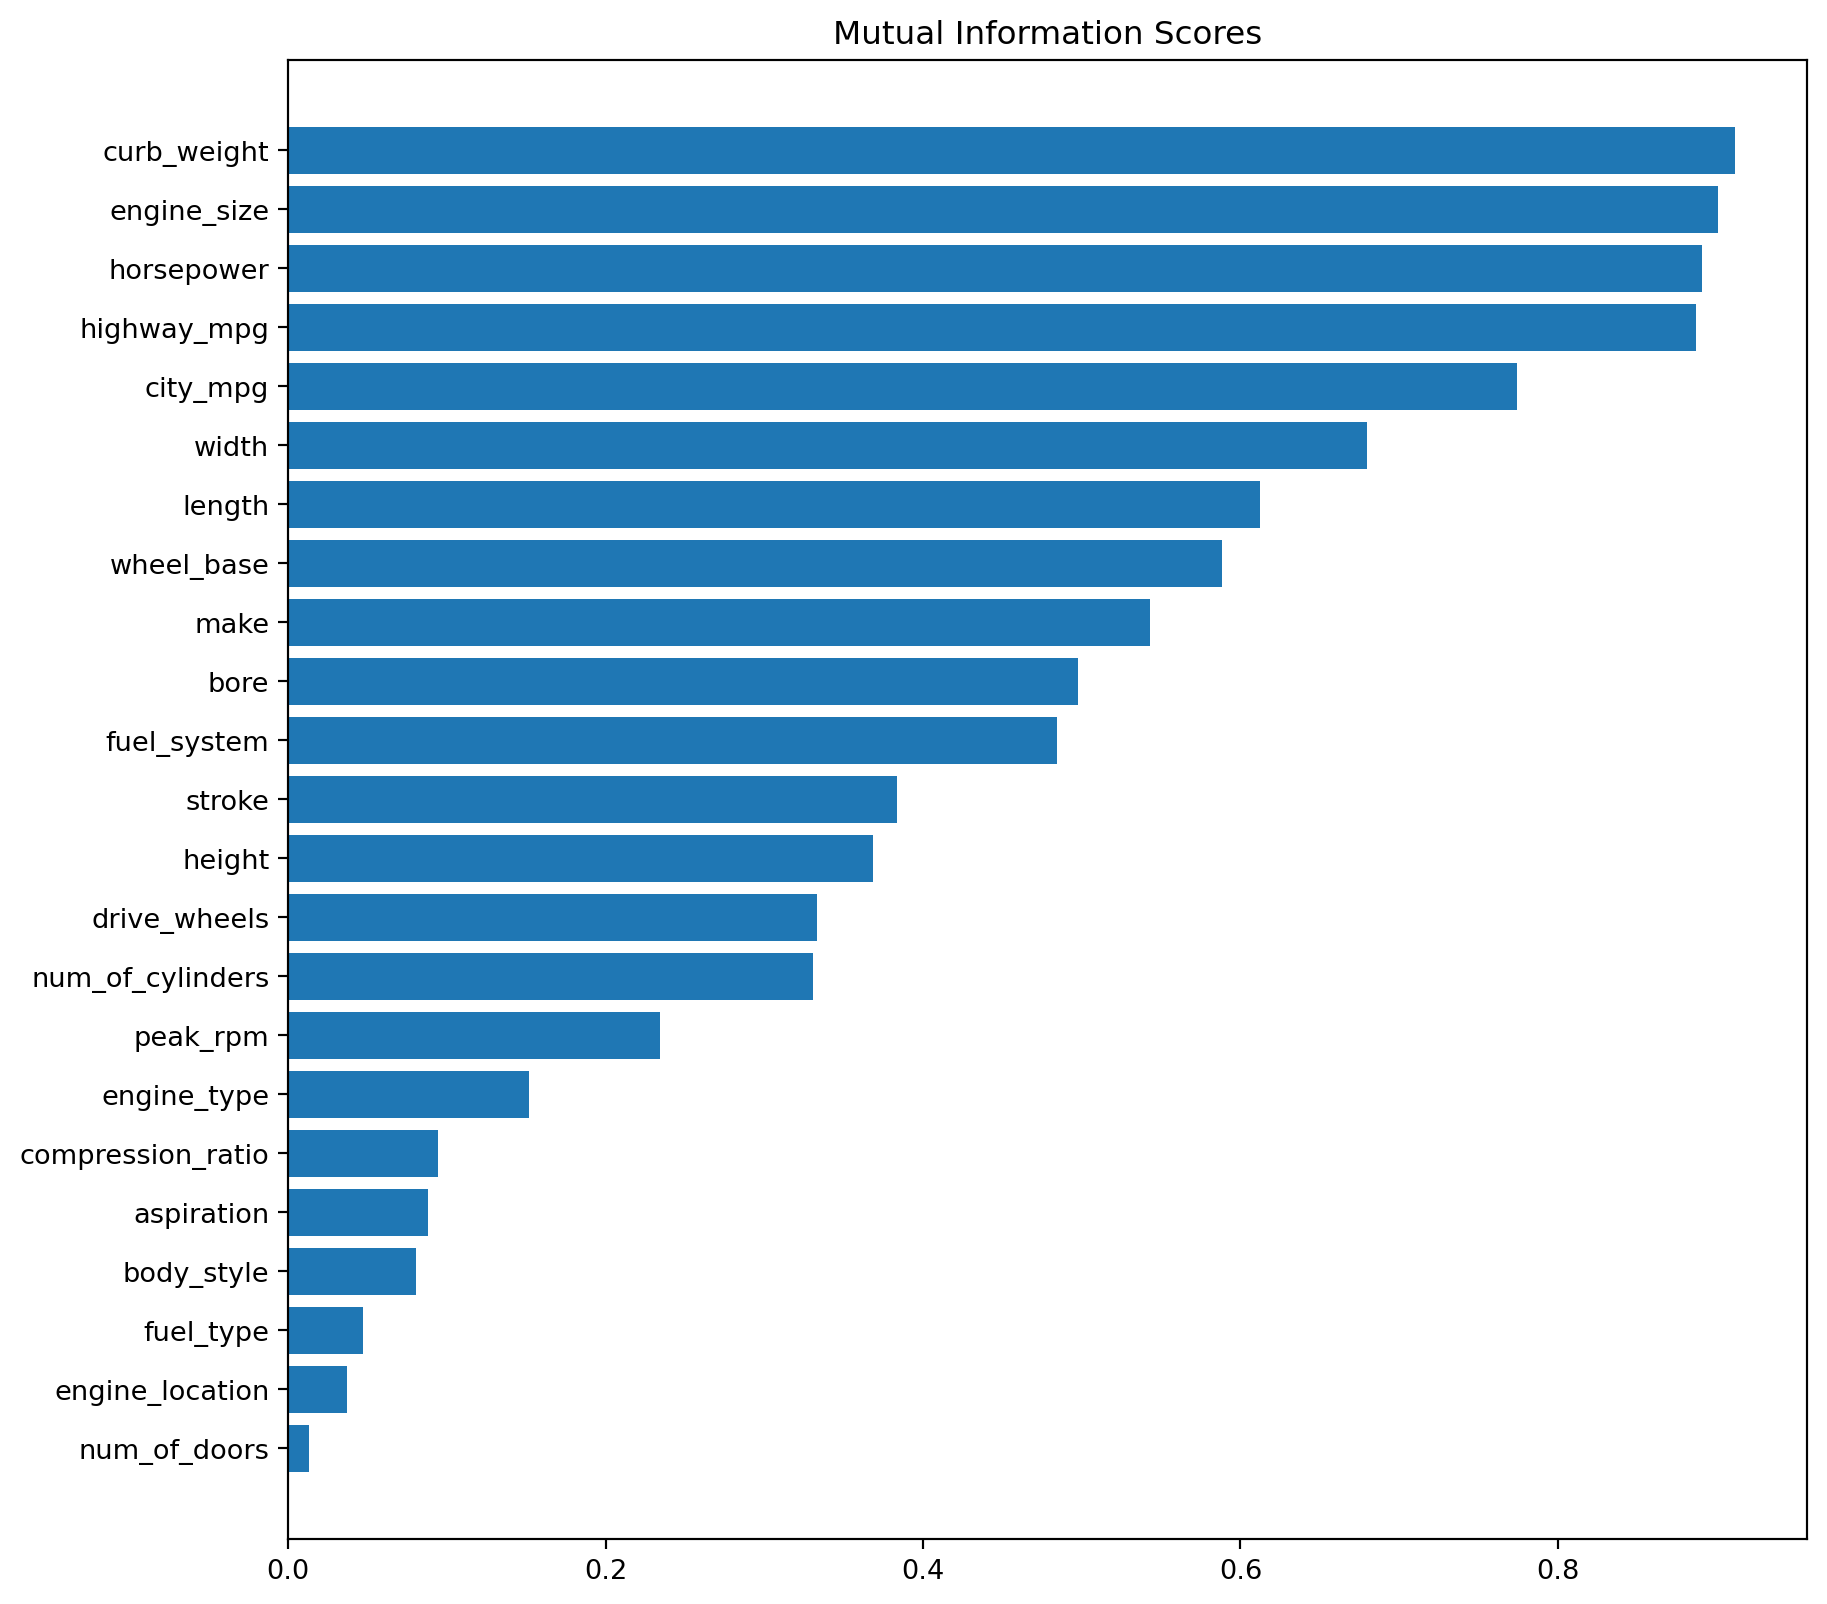

In [10]:
# visualize the results
plt.figure(figsize=(10,10), dpi=196)
plt.barh(np.arange(len(mi_scores)), mi_scores)
plt.yticks(np.arange(len(mi_scores)), mi_scores.index)
plt.title('Mutual Information Scores')

# plt.savefig('./mi_scores.png')
plt.show()

In [11]:
# split dataset on test and train subsets
X_train, X_test, y_train, y_test = (train_test_split(autos.drop('price', axis=1), autos['price'], test_size=0.3, random_state=42))

In [12]:
# encode categorial features
encoder = ce.TargetEncoder()
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)


In [13]:
# build RandomForestRegression model
mod_rnd_frs = (RandomForestRegressor(random_state=42).fit(X_train, y_train))

prd_rnd_frs = mod_rnd_frs.predict(X_test)

mape = mean_absolute_percentage_error(y_test, prd_rnd_frs)

print(f'Accuracy: {1 - mape:.1%}')

Accuracy: 87.4%


In [14]:
# build RandomForestRegression model with max depth equals to 4 
mod_rnd_frs_upd = (RandomForestRegressor(random_state=42, max_depth=7).fit(X_train, y_train))

prd_rnd_frs_upd = mod_rnd_frs_upd.predict(X_test)

mape_upd = mean_absolute_percentage_error(y_test, prd_rnd_frs_upd)

print(f'Accuracy of updated decision tree: {1 - mape_upd:.1%}')

Accuracy of updated decision tree: 87.5%


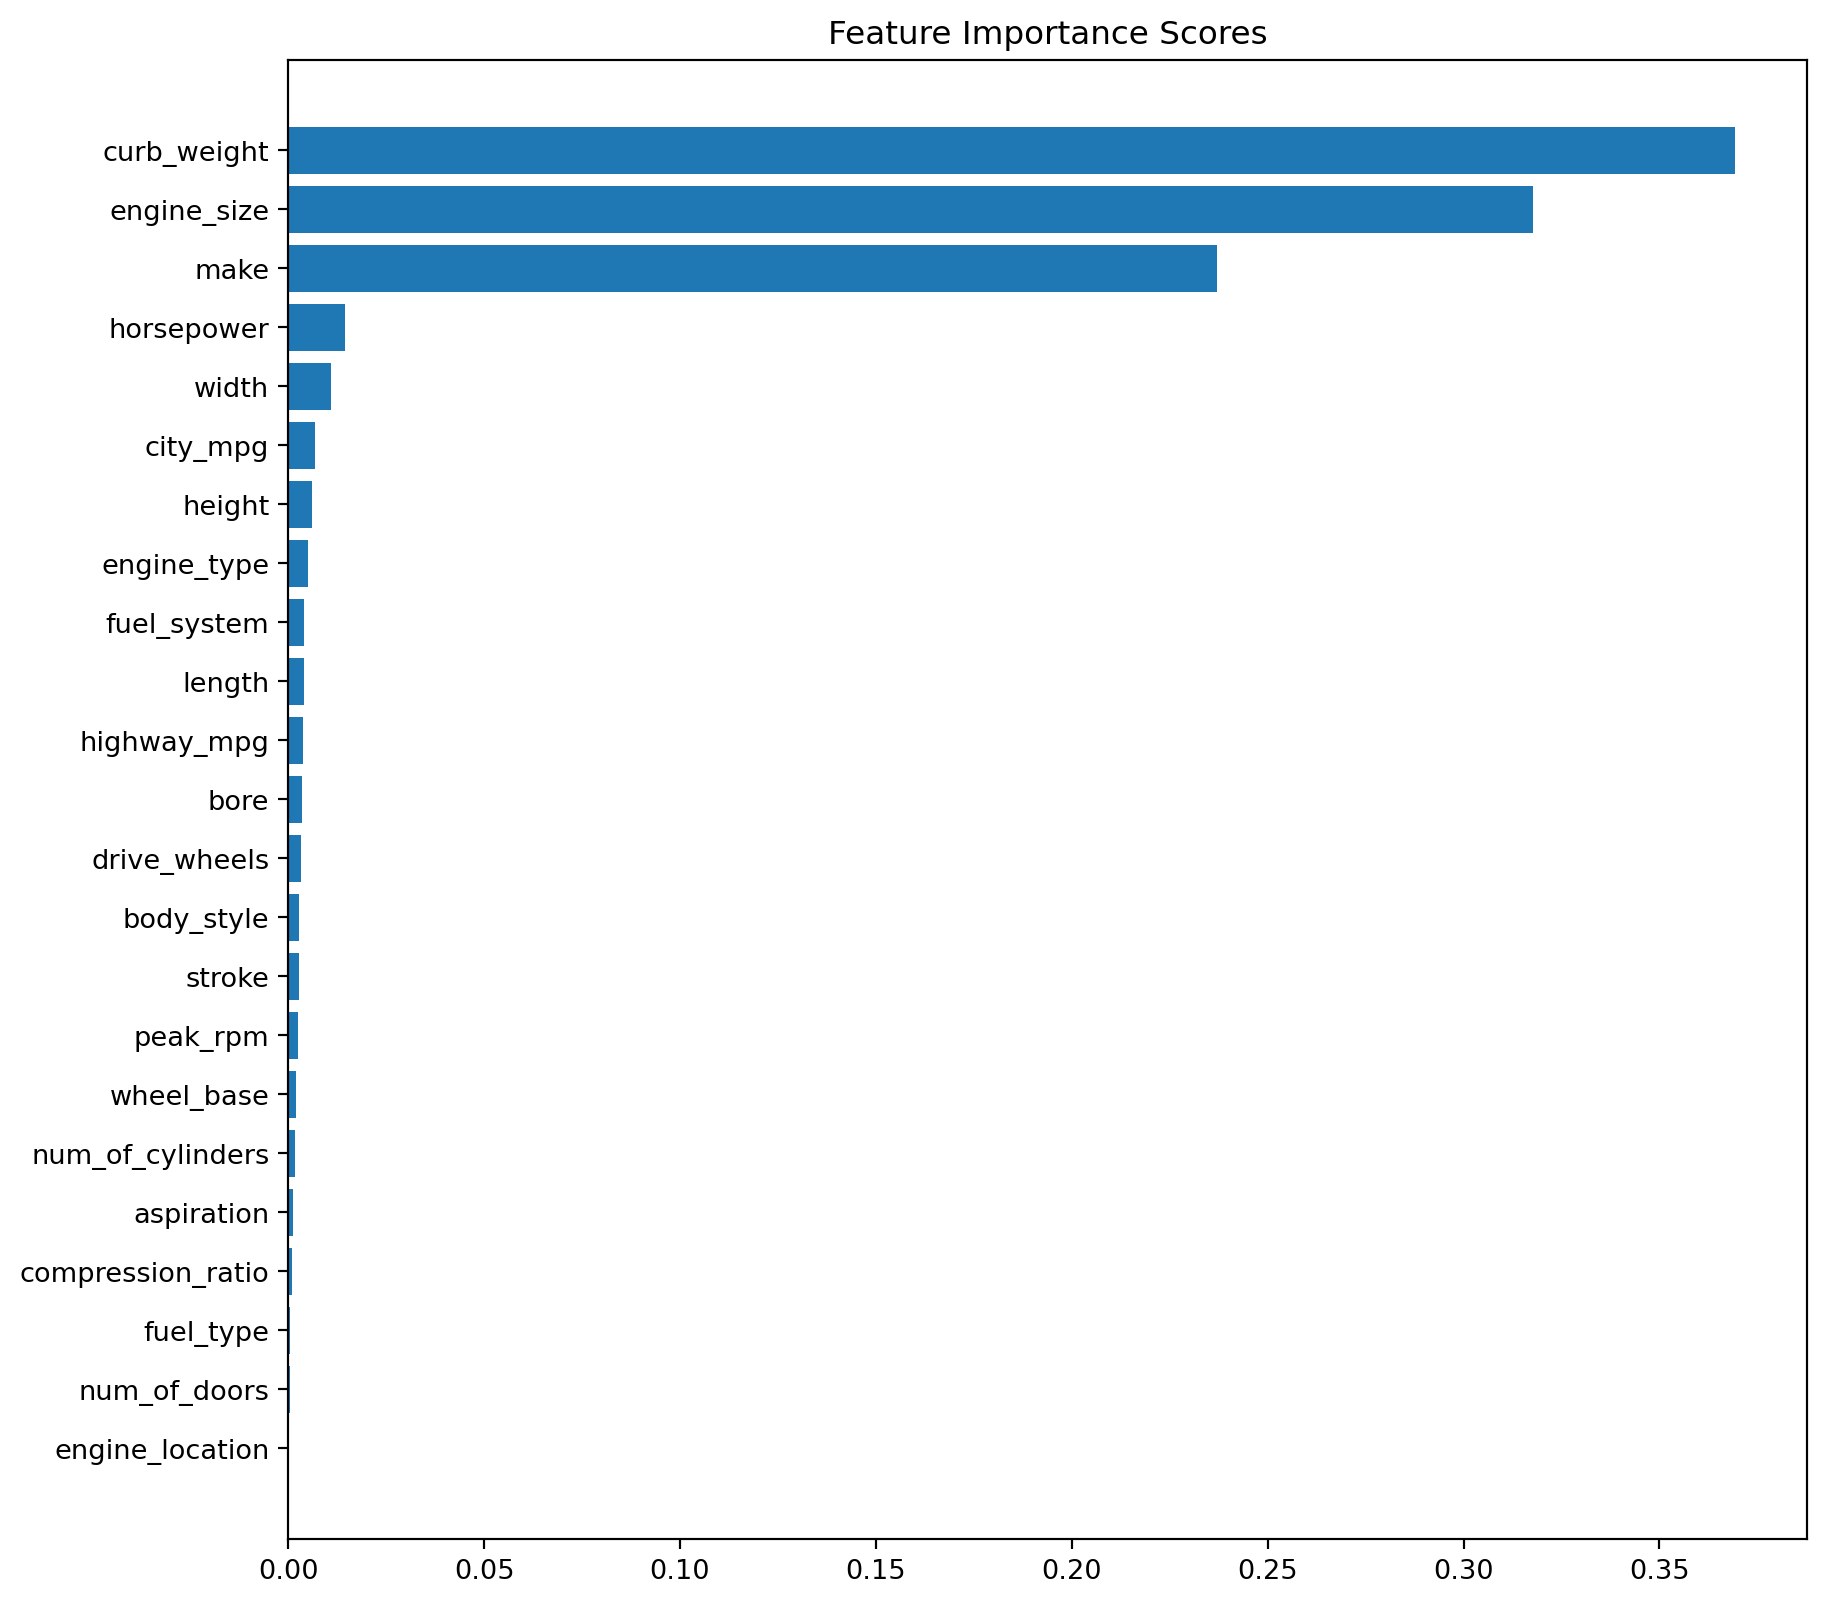

In [15]:
# define feature importance in decision tree model
plt.figure(figsize=(10,10), dpi=196)
feat_importance_scores=pd.Series(data=mod_rnd_frs_upd.feature_importances_, index=X.columns).sort_values(ascending=True)
plt.barh(np.arange(len(feat_importance_scores)), feat_importance_scores)
plt.yticks(np.arange(len(feat_importance_scores)), feat_importance_scores.index)
plt.title('Feature Importance Scores')
#(pd.Series(data=mod_rnd_frs.feature_importances_, index=X.columns).sort_values(ascending=True).plot.barh())

# plt.savefig('./dec_tree_features_importance.png')
plt.show()

In [16]:
# rank mutual information scores
frame_mi={'feature_mi': mi_scores.index, 'MI Score': mi_scores}
mi_scores_df=pd.DataFrame(frame_mi)

mi_scores_df['pct_rank_mi']=mi_scores_df['MI Score'].rank(pct=True)
mi_scores_df

,feature_mi,MI Score,pct_rank_mi
num_of_doors,num_of_doors,0.012705,0.043478
engine_location,engine_location,0.036912,0.086957
fuel_type,fuel_type,0.047298,0.130435
body_style,body_style,0.080515,0.173913
aspiration,aspiration,0.087755,0.217391
compression_ratio,compression_ratio,0.093994,0.260870
engine_type,engine_type,0.151544,0.304348
peak_rpm,peak_rpm,0.234449,0.347826
num_of_cylinders,num_of_cylinders,0.330589,0.391304
drive_wheels,drive_wheels,0.332973,0.434783


In [17]:
# rank feature importance scores
frame_fi={'feature_fi': feat_importance_scores.index, 'FI Score': feat_importance_scores}
fi_scores_df=pd.DataFrame(frame_fi)

fi_scores_df['pct_rank_fi']=fi_scores_df['FI Score'].rank(pct=True)
fi_scores_df

,feature_fi,FI Score,pct_rank_fi
engine_location,engine_location,0.000019,0.043478
num_of_doors,num_of_doors,0.000297,0.086957
fuel_type,fuel_type,0.000361,0.130435
compression_ratio,compression_ratio,0.000969,0.173913
aspiration,aspiration,0.001277,0.217391
num_of_cylinders,num_of_cylinders,0.001748,0.260870
wheel_base,wheel_base,0.002046,0.304348
peak_rpm,peak_rpm,0.002476,0.347826
stroke,stroke,0.002656,0.391304
body_style,body_style,0.002726,0.434783


In [18]:
# visualize grouped barsplots for mutual information and feature importance scores comparison
scores_df=pd.concat([mi_scores_df, fi_scores_df],axis=1, join="inner")

scores_df.drop('feature_fi', axis=1, inplace=True)


scores_df=scores_df.rename(columns={'feature_mi':'feature'})


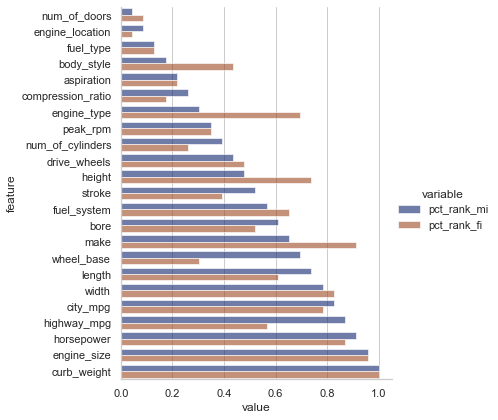

In [19]:
melted=pd.melt(scores_df, id_vars=['feature'], value_vars=['pct_rank_mi', 'pct_rank_fi'])

sns.set_theme(style="whitegrid")
sns.catplot(data=melted, kind='bar', x='value', y='feature', hue='variable', errorbar="sd", palette="dark", alpha=.6, height=6)

# plt.savefig('./grouped_rank.png')
plt.show()

In [20]:
# Conclusion
# Observing grouping barsplots we can see that not all features have the same importance comparing different scores such as mutual information score and feature importance score.
# We see that 'curb_weight' and 'engine_size' are the most important features in the dataset according to both scores.
# But for example such features as 'make', 'height', 'engine_type' have lower importance according to mutual information score, but have great importance in Decision Tree model according to it's characteristics ('Gini Impurity', 'Entropy', 'Misclassification Error') 
# And such feature as 'highway_mpg', 'length', 'wheel_base' vise versa have lower importance for the given model. 
# So we can conclude that we should investigate feature importance for each model and use different methods and technics based on model type, different scores comparison, domain specific and etc.

In [21]:
# build RandomForestRegression model without unimportant features according to .feature_importances_() method
unimp_features=['num_of_doors', 'engine_location', 'compression_ratio', 'wheel_base', 'num_of_cylinders']
mod_rnd_frs_upd = (RandomForestRegressor(random_state=42).fit(X_train.drop(unimp_features, axis=1), y_train))

prd_rnd_frs_upd = mod_rnd_frs_upd.predict(X_test.drop(unimp_features, axis=1))

mape_upd = mean_absolute_percentage_error(y_test, prd_rnd_frs_upd)

print(f'Accuracy of decision tree without unimportant feutures: {1 - mape_upd:.1%}')

# We see that deleting of features with the lowest importance doesn't lead to higher model accuracy in our case







Accuracy of decision tree without unimportant feutures: 87.2%


Conclusion
Observing grouping barsplots we can see that not all features have the same importance comparing different scores such as mutual information score and feature importance score.
We see that 'curb_weight' and 'engine_size' are the most important features in the dataset according to both scores.
But for example such features as 'make', 'height', 'engine_type' have lower importance according to mutual information score, but have great importance in Decision Tree model according to it's characteristics ('Gini Impurity', 'Entropy', 'Misclassification Error') 
And such feature as 'highway_mpg', 'length', 'wheel_base' vise versa have lower importance for the given model. 
So we can conclude that we should investigate feature importance for each model and use different methods and technics based on model type, different scores comparison, domain specific and etc.